https://github.com/tbmoon/facenet/blob/b3aec1a930f22a5a9597efa7072373c0ff93663f/test-result.ipynb

In [1]:
import torch
from torchvision import transforms
import torchvision
from PIL import Image
from models import FaceNetModel
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from random import sample, choice
import json
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import pandas as pd
from models import model_921, model_920
from eval_metrics import evaluate, plot_roc

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
root = '/home/jupyter/data/face-image/training_aihub_family/'
df = pd.read_csv('datasets/test_dataset.csv')
classes = df['class'].unique()
class_row_counts = df['class'].value_counts()
images_above1_index = class_row_counts[class_row_counts > 2].index.tolist()
images_above1 = df[df['class'].isin(images_above1_index)]

In [4]:
# from facenet_pytorch import InceptionResnetV1
# model = InceptionResnetV1(pretrained='vggface2')
# model.to(device)
# model = torch.nn.DataParallel(model)
# model = model_921().to(device)
model = FaceNetModel().to(device)
state = torch.load('./log/log4/last_checkpoint.pth')
model.load_state_dict(state["state_dict"])


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [5]:
trfrm = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
topil = transforms.ToPILImage()
totensor = transforms.Compose(trfrm.transforms[:-1])

In [6]:
def get_same_notsame(size):
    notsame = []
    same = []
    while len(same) < size:
        class_ = images_above1.sample().iloc[0]['class']
        same_pairs = images_above1[images_above1['class'] == class_].sample(2)
        same.append((same_pairs.iloc[0], same_pairs.iloc[1]))
    while len(notsame) < size:
        pair1 = images_above1.sample()
        pair2 = images_above1[images_above1['class'] != pair1.iloc[0]['class']].sample()
        notsame.append((pair1.iloc[0], pair2.iloc[0]))
    return {'same': same, 'notsame': notsame}

def get_random_pairs(size):
    pairs = []
    while len(pairs) < size:
        must_same = choice([True, False])
        if must_same:
            class_ = images_above1.sample().iloc[0]['class']
            same_pairs = images_above1[images_above1['class'] == class_].sample(2)
            pairs.append((same_pairs.iloc[0], same_pairs.iloc[1]))
        else:
            pair1 = images_above1.sample()
            pair2 = images_above1[images_above1['class'] != pair1.iloc[0]['class']].sample()
            pairs.append((pair1.iloc[0], pair2.iloc[0]))
    return pairs
    
def imshow(img,text=None,should_save=False):
    npimg = torchvision.utils.make_grid(img).numpy()
    plt.axis("off")
    if text:
        plt.text(220, 243, text, fontweight='bold', horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_distance(timg1, timg2):
    model.eval()
    with torch.no_grad():
        embed1 = model(timg1.unsqueeze(0))
        embed2 = model(timg2.unsqueeze(0))
    return F.pairwise_distance(embed1, embed2).item()

def get_path(root, item):
    return os.path.join(root, item['name'], item['id'] + "."+item['ext'])

In [7]:
random_pairs = get_random_pairs(30)

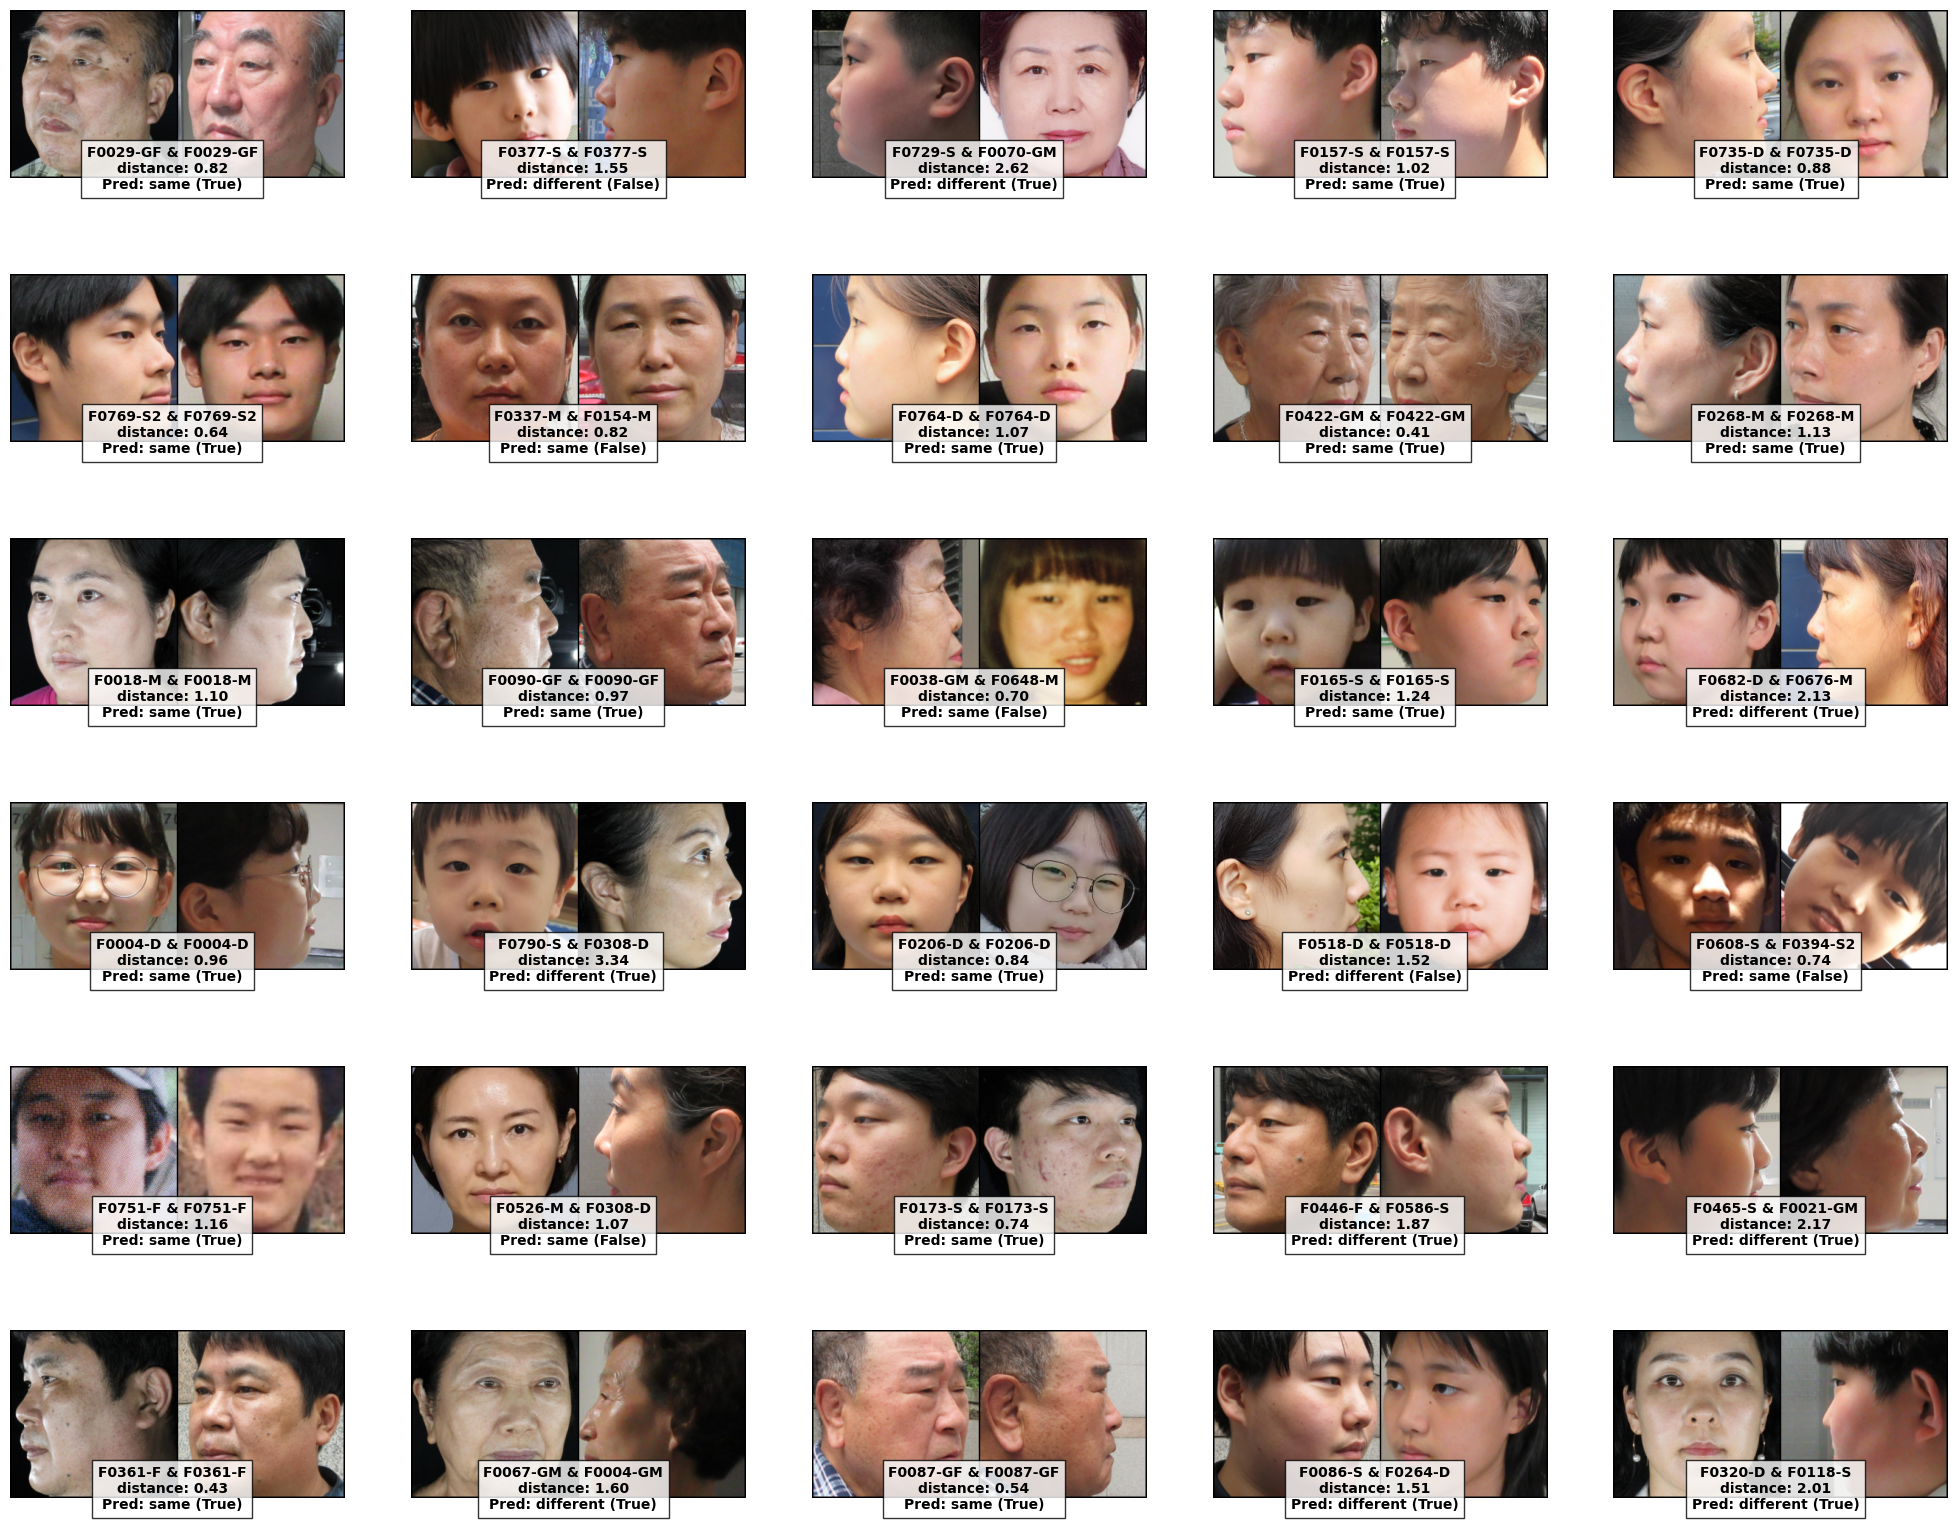

In [8]:
result = []
threshold = 1.5
plt.figure(figsize=(25, 20))
os.makedirs("random/"+str(threshold), exist_ok=True)
model.eval()
with torch.no_grad():
    for num, item in enumerate(random_pairs, 1):
        a,b = map(lambda i: trfrm(Image.open(get_path(root, i))).unsqueeze(0).to(device), item)
        x0, x1 = map(lambda i: totensor(Image.open(get_path(root, i))).unsqueeze(0), item)
        embed1, embed2 = model(a), model(b)
        concatenated = torch.cat((x0,x1),0)
        euclidean_distance = F.pairwise_distance(embed1, embed2)
        name1, name2 = item[0]['name'], item[1]['name']
        not_same = euclidean_distance > threshold
        diff_class = int(item[0]['class'] != item[1]['class'])
        pred = ("same", "different")[not_same]
        actual = ("False", "True")[diff_class == not_same]
        greater = ("≤", ">")[not_same]
        text = f"{name1} & {name2}\ndistance: {euclidean_distance.item():.2f}\nPred: {pred} ({actual})"
        plt.subplot(6,5,num)
        imshow(concatenated, text)
plt.savefig('test-result.png')
plt.show()

In [14]:
result = defaultdict(list)
# plt.figure(figsize=(25, 15))
model.eval()
with torch.no_grad():
    for threshold in np.arange(0.5, 5, 0.1):
        os.makedirs("random/"+str(threshold), exist_ok=True)
        for num, item in enumerate(random_pairs, 1):
            a,b = map(lambda i: trfrm(Image.open(get_path(root, i))).unsqueeze(0).to(device), item)
            x0, x1 = map(lambda i: totensor(Image.open(get_path(root, i))).unsqueeze(0), item)
            embed1, embed2 = model(a), model(b)
            concatenated = torch.cat((x0,x1),0)
            euclidean_distance = F.pairwise_distance(embed1, embed2)
            name1, name2 = item[0]['name'], item[1]['name']
            not_same = euclidean_distance > threshold
            diff_class = int(item[0]['class'] != item[1]['class'])
            pred = ("sama", "berbeda")[not_same]
            actual = ("salah", "benar")[diff_class == not_same]
            result[threshold].append((diff_class == not_same).item())
            text = f"{name1} & {name2}\nJarak: {euclidean_distance.item():.2f}\nPrediksi: {pred} ({actual})"
#         plt.subplot(5,5,num)
#             imshow(concatenated, text)
#             plt.savefig("random/"+str(threshold)+"/random"+str(num)+".png")
#             plt.show()
# plt.show()

KeyboardInterrupt: 

In [15]:
x = result.keys()
y = [sum(i) for i in result.values()]

In [16]:
thres_df=pd.DataFrame(columns={'Threshold','Counts'})

for i, (thres, count) in enumerate(zip(x,y)):
    thres_df.loc[i]=[thres, count]
thres_df

,Threshold,Counts
0,0.5,14.0
1,0.6,8.0


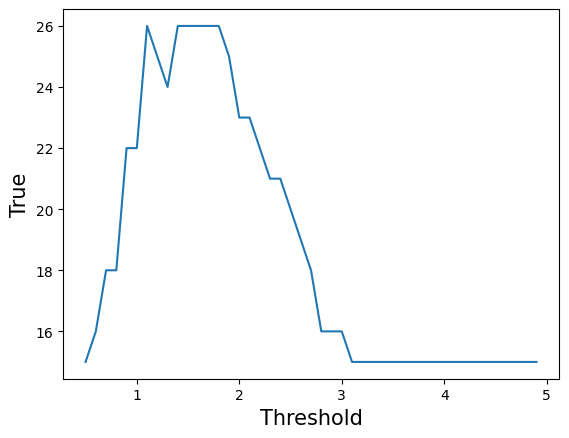

In [18]:
plt.xlabel('Threshold', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.plot(x,y)
plt.savefig('threshold.png')

In [9]:
from data_loader import get_dataloader

In [25]:
data_loaders, data_size = get_dataloader(
    '/home/jupyter/data/face-image/training_aihub_family/', 
    '/home/jupyter/data/face-image/training_aihub_family',
    'datasets/test_dataset.csv', 
    'datasets/test_dataset.csv',
    3000, 1000, 16, 8)

In [26]:
valid = data_loaders['valid']

In [29]:
model = FaceNetModel().to(device)
state = torch.load('./log/log3/last_checkpoint.pth')
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [30]:

model.eval()
labels, distances = [], []
with torch.no_grad():
    for batch_idx, batch_sample in enumerate(valid):
        anc_img = batch_sample['anc_img'].to(device)
        pos_img = batch_sample['pos_img'].to(device)
        neg_img = batch_sample['neg_img'].to(device)

        anc_embed, pos_embed, neg_embed = model(anc_img), model(pos_img), model(neg_img)

        pos_dist = F.pairwise_distance(anc_embed, pos_embed)
        neg_dist = F.pairwise_distance(anc_embed, neg_embed)

        distances.append(pos_dist.data.cpu().numpy())
        labels.append(np.ones(pos_dist.size(0)))

        distances.append(neg_dist.data.cpu().numpy())
        labels.append(np.zeros(neg_dist.size(0)))

labels = np.array([sublabel for label in labels for sublabel in label])
distances = np.array([subdist for dist in distances for subdist in dist])

tpr, fpr, accuracy, val, val_std, far, tp, fp, fn = evaluate(distances, labels)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2.0 / (1 / precision + 1 / recall)

print(
        {
            "true_positive": tp,
            "false_positive": fp,
            "false_negative": fn,
        }
    )
print(
    {"precision": precision, "recall": recall, "F1_score": f1_score}
)
print('Accuracy = {:.8f}'.format(np.mean(accuracy)))
plot_roc(fpr, tpr, figure_name='roc.png')

{'true_positive': 86, 'false_positive': 33, 'false_negative': 10}
{'precision': 0.7226890756302521, 'recall': 0.8958333333333334, 'F1_score': 0.8}
Accuracy = 0.78200000
